### Step 3

# Create geological model

#### Import Python libraries

In [34]:
import sys, warnings
warnings.filterwarnings('ignore')
sys.path.append("../../gempy")

import numpy as np
import gempy as gp # importing gempy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

#### Load the interface and foliation data files and determine model extent

In [35]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000], 
                        resolution=[50, 50, 50],
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

#### Set stratigraphic order

<div class="alert alert-info">
**Your task:** Enter the correct ordering of formation names as strings in the list variable *orderf* in the code cell below and execute the following code cell to set the stratigraphic order for the modeling software.
</div>

In [64]:
order_formations = ["Unit4", "Unit3", "Unit2", "Unit1"]

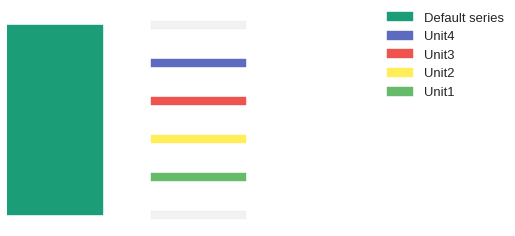

In [65]:
gp.set_series(geo_data, {"Default series": order_formations},
             order_formations = order_formations)


#### Data visualization

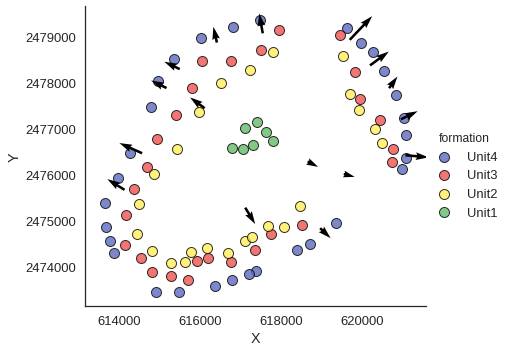

In [38]:
gp.plot_data(geo_data, direction="z")

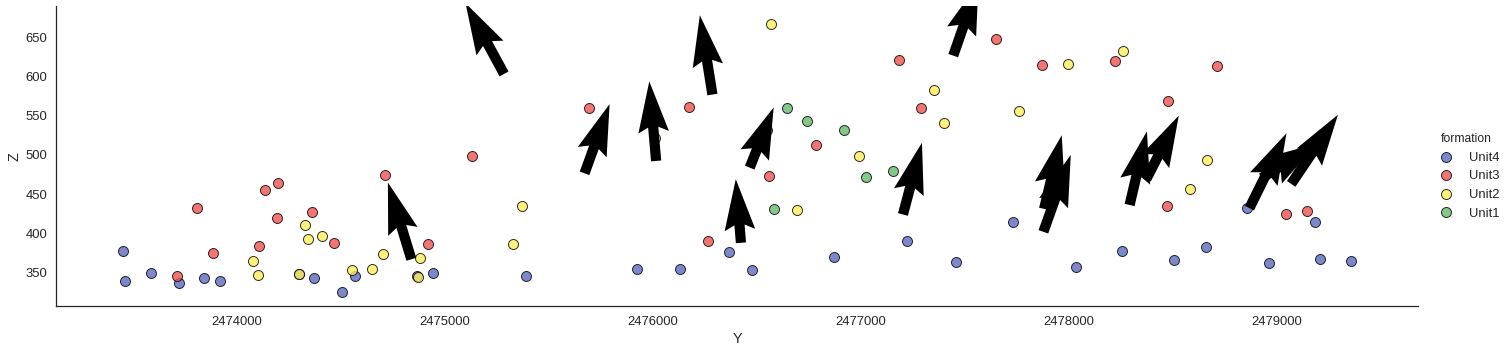

In [39]:
gp.plot_data(geo_data, direction="x")

#### Visualization of input data in 3-D using VTK

<div class="alert alert-danger">
**Important note**: 3D-Visualization using VTK is not available if you use Docker to run this exercise. This part is **optional**.
</div>

In [40]:
gp.plot_data_3D(geo_data)

#### Computing the 3D Model

<div class="alert alert-info">
**Note**: The following code cell will need several minutes to execute, depending on your system configuration.
</div>

In [41]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float32", u_grade=[3])

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


In [42]:
lith_block, fault_block = gp.compute_model(interp_data)
print("3-D geological model calculated.")

3-D geological model calculated.


### Step 4

## Post-processing results for visualization and interpretation

#### 2D Sections

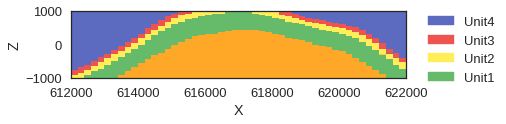

In [43]:
gp.plot_section(geo_data, lith_block[0], 25, direction='y', plot_data=False)

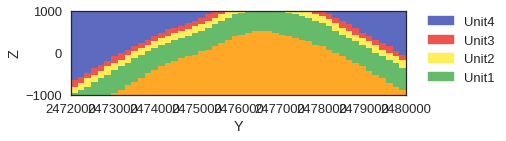

In [44]:
gp.plot_section(geo_data, lith_block[0], 25, direction='x', plot_data=False)

#### Pseudo-3D surfaces

In [45]:
v_l, s_l = gp.get_surfaces(interp_data, potential_lith=lith_block[1], step_size=2)

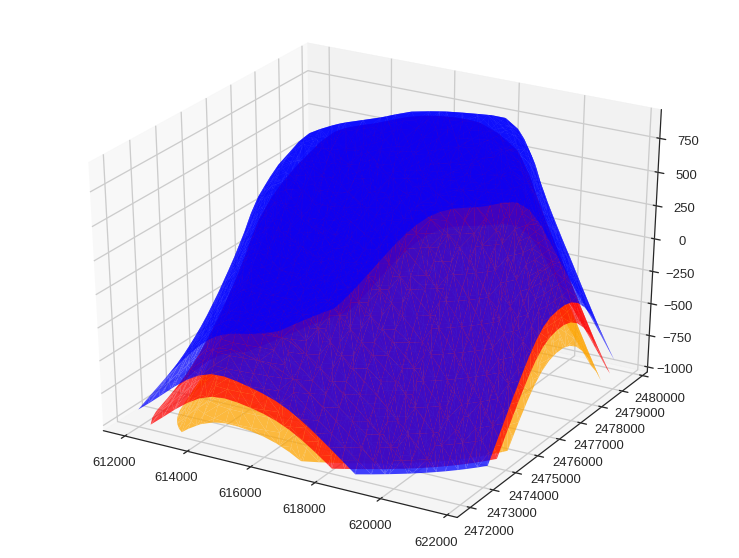

In [46]:
fig = plt.figure(figsize=(13,10))
ax = fig.add_subplot(111, projection='3d')

cs = ["blue", "red", "orange"]



for i in range(3):
    surf = ax.plot_trisurf(v_l[i][:,0], v_l[i][:,1], v_l[i][:,2], 
                           color=cs[i], linewidth=0, alpha=0.75, shade=False)

#### 3D Visualization using VTK

<div class="alert alert-danger">
**Important note**: 3D-Visualization using VTK is not available if you use Docker to run this exercise. This part is **optional**.
</div>

In [47]:
gp.plot_surfaces_3D(geo_data, v_l, s_l)

#### Exporting a geological map

In [56]:
import gdal
geotiff_filepath = "../data/dome_sub_sub_utm.tif"
raster = gdal.Open(geotiff_filepath)
dtm = raster.ReadAsArray()

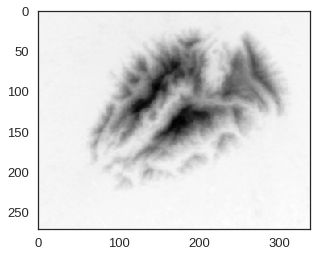

In [57]:
import matplotlib.pyplot as plt
plt.imshow(dtm)
plt.show()

In [58]:
# here are the raster dimensions:
raster.RasterXSize, raster.RasterYSize
geoinformation = raster.GetGeoTransform()

get DTM corners:


In [59]:
dtm_E_min = geoinformation[0]
dtm_E_max = geoinformation[0] + geoinformation[1] * raster.RasterXSize
dtm_N_min = geoinformation[3] + geoinformation[5] * raster.RasterYSize
dtm_N_max = geoinformation[3]
dtm_E_min, dtm_E_max, dtm_N_min, dtm_N_max

(612000.0, 622000.0, 2472000.0, 2480000.0)

In [60]:
# define range for x, y - values
X_range = np.arange(dtm_E_min, dtm_E_max, geoinformation[1])
Y_range = np.arange(dtm_N_min, dtm_N_max, np.abs(geoinformation[5]))
XX, YY = np.meshgrid(X_range, Y_range)

Create list of input points for interpolation with gempy:

In [61]:
points = np.array(list(zip(XX.ravel(), YY.ravel(), dtm.ravel())))

In [62]:
points

array([[  6.12000000e+05,   2.47200000e+06,   3.38000000e+02],
       [  6.12029499e+05,   2.47200000e+06,   3.34000000e+02],
       [  6.12058997e+05,   2.47200000e+06,   3.34000000e+02],
       ..., 
       [  6.21911504e+05,   2.47997048e+06,   2.99000000e+02],
       [  6.21941003e+05,   2.47997048e+06,   2.97000000e+02],
       [  6.21970501e+05,   2.47997048e+06,   2.99000000e+02]])

Build basic gempy using _data_ extent (_resolution_ does not matter, as far as I can tell):

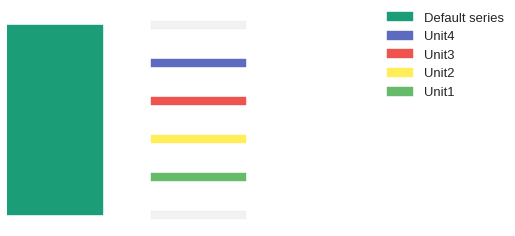

In [66]:
geo_data=gp.create_data(extent=[612000, 622000, 2472000, 2480000, -1000, 1000],  
                        resolution=[1, 1, 1], 
                        path_f = "../data/gempy_foliations.csv",
                        path_i = "../data/gempy_interfaces.csv")

gp.set_series(geo_data, {"Default series": np.unique(geo_data.interfaces["formation"].values)},
             order_formations = order_formations)

Now here the "trick": replace grid points with DTM grid points:

In [67]:
geo_data.grid.grid = points

Perform the "usual" interpolation step:

In [68]:
interp_data = gp.InterpolatorInput(geo_data, dtype="float32")
lith_block, fault_block = gp.compute_model(interp_data)

Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32


And here: **the geological map**:

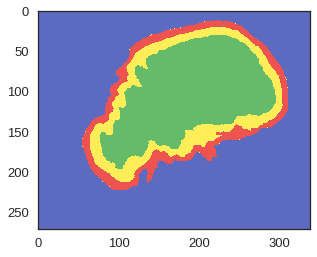

In [69]:
geo_map = lith_block[0].copy().reshape((271,339))
# adjust scale
geo_map += 1
# adjust misfits:
geo_map[np.where(geo_map==5)] = 1
geo_map[np.where(geo_map==6)] = 2
geo_map[np.where(geo_map==7)] = 3
geo_map[np.where(geo_map==8)] = 4
geo_map[np.where(geo_map==1)] = 5
geo_map -= 1
# change to int for later use:
geo_map = geo_map.astype('int16')
# adjust orientation:
geo_map = geo_map[::-1,:]
plt.imshow(geo_map, cmap=gp.colors.cmap, norm=gp.colors.norm)
# plt.colorbar()

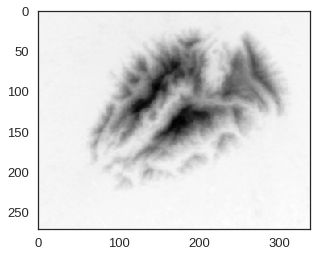

In [70]:
import matplotlib.pyplot as plt
plt.imshow(dtm)
plt.show()

In [71]:
np.min(dtm), np.max(dtm)

(289, 781)

In [72]:
file = geotiff_filepath
outFileName = "/data/geomap.tif"
# transform data
# geo_map = geo_map.astype('int16')
ds = gdal.Open(file)
band = ds.GetRasterBand(1)
arr = band.ReadAsArray()
[cols, rows] = arr.shape
# arr_min = arr.min()
# arr_max = arr.max()
# arr_mean = int(arr.mean())
# arr_out = np.where((arr < arr_mean), 10000, arr)
driver = gdal.GetDriverByName("GTiff")
# options = ['PHOTOMETRIC=RGB', 'PROFILE=GeoTIFF']
options = ['PROFILE=GeoTiff', 'PHOTOMETRIC=RGB', 'COMPRESS=JPEG']
# outdata = driver.Create(outFileName, rows, cols, 3, gdal.GDT_UInt16, options=options)
outdata = driver.Create(outFileName, rows, cols, 3, gdal.GDT_Byte, options=options)


outdata.SetGeoTransform(ds.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(ds.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(geo_map*64)
outdata.GetRasterBand(2).WriteArray(geo_map*64)
outdata.GetRasterBand(3).WriteArray(geo_map*64)
# outdata.GetRasterBand(4).WriteArray(np.ones_like(geo_map)*100)
outdata.GetRasterBand(1).SetColorInterpretation(gdal.GCI_RedBand)
outdata.GetRasterBand(2).SetColorInterpretation(gdal.GCI_GreenBand)
outdata.GetRasterBand(3).SetColorInterpretation(gdal.GCI_BlueBand)
# outdata.GetRasterBand(4).SetColorInterpretation(gdal.GCI_AlphaBand)


# outdata.GetRasterBand(1).SetNoDataValue(999)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None

AttributeError: 'NoneType' object has no attribute 'SetGeoTransform'

In [ ]:
plt.imshow(geo_map)
geo_map[np.where(geo_map == 0)] = 10
plt.colorbar()
plt.show()

In [ ]:
arr.dtype

In [ ]:
geo_map.dtype

In [ ]:
ds = gdal.Open(file)

In [ ]:
ds.GetRasterBand

In [ ]:
np.min(geo_map), np.max(geo_map*64)